## Model Selection and Hyper Parameter Tuning

In [1]:
# 1. IMPORTS AND DATA LOADING
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score


In [2]:
# Load California Housing dataset
housing = fetch_openml(name="california_housing", version=1, as_frame=True)
X = housing.data
y = housing.target.astype(float)


In [3]:
# Display basic info
print(f"Dataset shape: {X.shape}")
print(f"Features: {X.columns.tolist()}")
print(f"Target range: ${y.min():,.0f} to ${y.max():,.0f}")


Dataset shape: (20640, 9)
Features: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'ocean_proximity']
Target range: $14,999 to $500,001


In [4]:
# 2. THE TRAIN-VALIDATION-TEST SPLIT PROBLEM

# First, let's see the problem with no split
model = DecisionTreeRegressor(random_state=42)
X_encoded = pd.get_dummies(X)


In [5]:
# Bad approach: Train and test on same data
model.fit(X_encoded, y)
predictions = model.predict(X_encoded)
error = mean_absolute_error(y, predictions)
print(f"\nMAE when training and testing on same data: ${error:,.2f}")



MAE when training and testing on same data: $0.00


In [6]:
# Proper approach: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [7]:
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)


In [8]:
train_error = mean_absolute_error(y_train, train_predictions)
test_error = mean_absolute_error(y_test, test_predictions)


In [9]:
print(f"\nTrain MAE: ${train_error:,.2f}")
print(f"Test MAE: ${test_error:,.2f}")
print(f"Difference: ${test_error - train_error:,.2f} → This indicates OVERFITTING!")



Train MAE: $0.00
Test MAE: $43,437.49
Difference: $43,437.49 → This indicates OVERFITTING!


In [10]:
# 3. CROSS-VALIDATION TO THE RESCUE

# Cross-validation gives more reliable error estimates
cv_scores = cross_val_score(model, X_encoded, y, 
                           scoring='neg_mean_absolute_error', 
                           cv=5, n_jobs=-1)


In [11]:
# Convert negative MAE to positive
cv_errors = -cv_scores
print(f"\nCross-validation results (5-fold):")
print(f"MAE per fold: {cv_errors.round(2)}")
print(f"Mean CV MAE: ${cv_errors.mean():,.2f} ± ${cv_errors.std():,.2f}")



Cross-validation results (5-fold):
MAE per fold: [70212.73 62761.37 62300.99 86722.75 67434.67]
Mean CV MAE: $69,886.50 ± $8,920.59


In [12]:
# 4. FINDING THE SWEET SPOT: UNDERFITTING VS OVERFITTING

# Let's explore how model complexity affects performance
max_depths = [1, 3, 5, 10, 15, 20, 25, 30]
train_errors = []
test_errors = []

for depth in max_depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Train error
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    train_errors.append(mean_absolute_error(y_train, train_pred))
    
    # Test error
    test_pred = model.predict(X_test)
    test_errors.append(mean_absolute_error(y_test, test_pred))


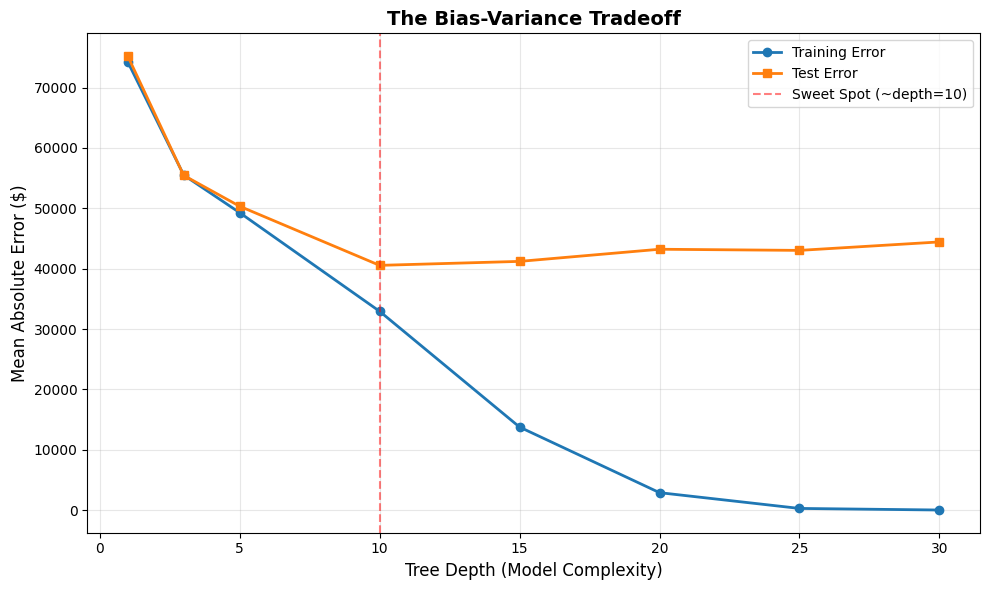

In [13]:
# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, 'o-', label='Training Error', linewidth=2)
plt.plot(max_depths, test_errors, 's-', label='Test Error', linewidth=2)
plt.xlabel('Tree Depth (Model Complexity)', fontsize=12)
plt.ylabel('Mean Absolute Error ($)', fontsize=12)
plt.title('The Bias-Variance Tradeoff', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='Sweet Spot (~depth=10)')
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
print("\nKey Observations:")
print("• Low depth (1-3): High error on both → UNDERFITTING (high bias)")
print("• High depth (20+): Low train error but high test error → OVERFITTING (high variance)")
print("• Optimal depth (~10): Balanced performance → GOOD FIT")



Key Observations:
• Low depth (1-3): High error on both → UNDERFITTING (high bias)
• High depth (20+): Low train error but high test error → OVERFITTING (high variance)
• Optimal depth (~10): Balanced performance → GOOD FIT


In [15]:
# 5. HYPERPARAMETER TUNING IN ACTION

# Load a classification dataset for demonstration
print("\n" + "="*60)
print("HYPERPARAMETER TUNING DEMONSTRATION")
print("="*60)



HYPERPARAMETER TUNING DEMONSTRATION


In [16]:
# Load blood transfusion dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data"
transfusion_df = pd.read_csv(url)


In [17]:
# Rename columns
transfusion_df.columns = ['recency', 'frequency', 'monetary', 'time', 'donated']


In [18]:
X_trans = transfusion_df.drop('donated', axis=1)
y_trans = transfusion_df['donated']

print(f"\nTransfusion dataset: {X_trans.shape[0]} samples, {X_trans.shape[1]} features")
print(f"Class balance: {y_trans.value_counts().to_dict()}")



Transfusion dataset: 748 samples, 4 features
Class balance: {0: 570, 1: 178}


In [19]:
# Split data
X_train_trans, X_test_trans, y_train_trans, y_test_trans = train_test_split(
    X_trans, y_trans, test_size=0.3, random_state=42
)


In [20]:
# 6. MANUAL HYPERPARAMETER SEARCH

print("\n1. MANUAL SEARCH (Brute Force)")
print("-" * 40)

best_score = 0
best_params = {}

# Define search space manually
learning_rates = [0.001, 0.01, 0.1]
max_leaf_nodes_list = [5, 10, 20, 30]

for lr in learning_rates:
    for nodes in max_leaf_nodes_list:
        # Create pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', HistGradientBoostingClassifier(
                learning_rate=lr,
                max_leaf_nodes=nodes,
                random_state=42
            ))
        ])
        
        # Cross-validation score
        scores = cross_val_score(pipeline, X_train_trans, y_train_trans, 
                                cv=3, scoring='accuracy')
        mean_score = scores.mean()
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = {'learning_rate': lr, 'max_leaf_nodes': nodes}
        
        print(f"LR={lr}, Nodes={nodes}: Accuracy = {mean_score:.3f}")

print(f"\nBest manual params: {best_params}")
print(f"Best manual score: {best_score:.3f}")



1. MANUAL SEARCH (Brute Force)
----------------------------------------
LR=0.001, Nodes=5: Accuracy = 0.774
LR=0.001, Nodes=10: Accuracy = 0.774
LR=0.001, Nodes=20: Accuracy = 0.774
LR=0.001, Nodes=30: Accuracy = 0.774
LR=0.01, Nodes=5: Accuracy = 0.774
LR=0.01, Nodes=10: Accuracy = 0.772
LR=0.01, Nodes=20: Accuracy = 0.774
LR=0.01, Nodes=30: Accuracy = 0.774
LR=0.1, Nodes=5: Accuracy = 0.767
LR=0.1, Nodes=10: Accuracy = 0.763
LR=0.1, Nodes=20: Accuracy = 0.763
LR=0.1, Nodes=30: Accuracy = 0.763

Best manual params: {'learning_rate': 0.01, 'max_leaf_nodes': 5}
Best manual score: 0.774


In [21]:
# 7. GRID SEARCH (Automated)

print("\n2. GRID SEARCH (Systematic)")
print("-" * 40)



2. GRID SEARCH (Systematic)
----------------------------------------


In [22]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])


In [23]:
# Define parameter grid
param_grid = {
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__max_leaf_nodes': [5, 10, 20, 30]
}


In [24]:
# Perform grid search
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=0
)

grid_search.fit(X_train_trans, y_train_trans)

print(f"Best grid params: {grid_search.best_params_}")
print(f"Best grid score: {grid_search.best_score_:.3f}")


Best grid params: {'classifier__learning_rate': 0.01, 'classifier__max_leaf_nodes': 5}
Best grid score: 0.774


In [25]:
# 8. RANDOM SEARCH (Efficient)

print("\n3. RANDOM SEARCH (Efficient)")
print("-" * 40)



3. RANDOM SEARCH (Efficient)
----------------------------------------


In [26]:
# Define parameter distributions
param_dist = {
    'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
    'classifier__max_leaf_nodes': list(range(5, 51, 5))
}


In [27]:
# Perform random search (tries only 10 random combinations)
random_search = RandomizedSearchCV(
    pipeline,
    param_dist,
    n_iter=10,  # Only try 10 random combos (vs 24 in grid search)
    cv=3,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_trans, y_train_trans)

print(f"Best random params: {random_search.best_params_}")
print(f"Best random score: {random_search.best_score_:.3f}")


Best random params: {'classifier__max_leaf_nodes': 35, 'classifier__learning_rate': 0.05}
Best random score: 0.780


In [28]:
# 9. COMPARE ALL METHODS

print("\n" + "="*60)
print("COMPARISON OF HYPERPARAMETER TUNING METHODS")
print("="*60)

methods = {
    'Manual Search': (best_params, best_score),
    'Grid Search': (grid_search.best_params_, grid_search.best_score_),
    'Random Search': (random_search.best_params_, random_search.best_score_)
}

for method, (params, score) in methods.items():
    print(f"\n{method}:")
    print(f"  Parameters: {params}")
    print(f"  CV Accuracy: {score:.3f}")



COMPARISON OF HYPERPARAMETER TUNING METHODS

Manual Search:
  Parameters: {'learning_rate': 0.01, 'max_leaf_nodes': 5}
  CV Accuracy: 0.774

Grid Search:
  Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_leaf_nodes': 5}
  CV Accuracy: 0.774

Random Search:
  Parameters: {'classifier__max_leaf_nodes': 35, 'classifier__learning_rate': 0.05}
  CV Accuracy: 0.780


In [29]:
# 10. FINAL EVALUATION ON TEST SET

print("\n" + "="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)



FINAL EVALUATION ON TEST SET


In [30]:
# Train best model from grid search on full training data
best_model = grid_search.best_estimator_
best_model.fit(X_train_trans, y_train_trans)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"loss loss: {'log_loss'}, default='log_loss'The loss function to use in the boosting process.For binary classification problems, 'log_loss' is also known as logistic loss,binomial deviance or binary crossentropy. Internally, the model fits one treeper boosting iteration and uses the logistic sigmoid function (expit) asinverse link function to compute the predicted positive class probability.For multiclass classification problems, 'log_loss' is also known as multinomialdeviance or categorical crossentropy. Internally, the model fits one tree perboosting iteration and per class and uses the softmax function as inverse linkfunction to compute the predicted probabilities of the classes.",'log_loss'
,"learning_rate learning_rate: float, default=0.1The learning rate, also known as *shrinkage*. This is used as amultiplicative factor for the leaves values. Use ``1`` for noshrinkage.",0.01
,"max_iter max_iter: int, default=100The maximum number of iterations of the boosting process, i.e. themaximum number of trees for binary classification. For multiclassclassification, `n_classes` trees per iteration are built.",100
,"max_leaf_nodes max_leaf_nodes: int or None, default=31The maximum number of leaves for each tree. Must be strictly greaterthan 1. If None, there is no maximum limit.",5


In [31]:
# Predict on test set
test_predictions = best_model.predict(X_test_trans)
test_accuracy = accuracy_score(y_test_trans, test_predictions)

print(f"\nTest Accuracy: {test_accuracy:.3f}")
print(f"Improvement over default: +{(test_accuracy - 0.762):.3f}")



Test Accuracy: 0.733
Improvement over default: +-0.029


In [32]:
# 11. KEY TAKEAWAYS

print("\n" + "="*60)
print("KEY TAKEAWAYS")
print("="*60)

print("""
1. ALWAYS split your data:
   • Training set: For model learning
   • Validation set: For hyperparameter tuning
   • Test set: For final evaluation (use only once!)

2. Cross-validation gives more reliable performance estimates
   • Use 5-10 folds for most problems
   • Stratified folds for imbalanced data

3. Watch for overfitting/underfitting:
   • High training error → Underfitting (increase complexity)
   • Low training error but high test error → Overfitting (reduce complexity)

4. Hyperparameter tuning methods:
   • Manual: Good for small search spaces
   • Grid Search: Exhaustive but expensive
   • Random Search: Efficient for large spaces
   • Bayesian Optimization: Smart search (most efficient)

5. Golden rule: The test set is SACRED!
   Never tune hyperparameters on the test set.
""")


KEY TAKEAWAYS

1. ALWAYS split your data:
   • Training set: For model learning
   • Validation set: For hyperparameter tuning
   • Test set: For final evaluation (use only once!)

2. Cross-validation gives more reliable performance estimates
   • Use 5-10 folds for most problems
   • Stratified folds for imbalanced data

3. Watch for overfitting/underfitting:
   • High training error → Underfitting (increase complexity)
   • Low training error but high test error → Overfitting (reduce complexity)

4. Hyperparameter tuning methods:
   • Manual: Good for small search spaces
   • Grid Search: Exhaustive but expensive
   • Random Search: Efficient for large spaces
   • Bayesian Optimization: Smart search (most efficient)

5. Golden rule: The test set is SACRED!
   Never tune hyperparameters on the test set.

